By Nilusche Liyanaarachchi 2022



---


###Before we begin <br> 
Before running the code in this notebook, reset the runtime by going to<br>**Runtime -> Restart Runtime** in the menu above.




# Feed-Forward-Network for recognition of handwritten numbers
In this task the previous concept of a perceptron shall be used to construct a feed-forward-network.<br> The task of the network is to recognize handwritten number from 0 to 9 after beeing trained with the MNIST dataset, which consists of thousands of 28x28 grayscale images of handwritten numbers. <br>
<br>
The network shall be modelled so, that each pixel of the grayscale image is perceived by one perceptron on the inputlayer (I), thus 784 perceptrons are needed here. The hiddenlayer (H) shall have 200 perceptrons, followed by the outputlayer (O). Since we want to recognize the numbers from 0 to 9, the final output layer consists of 10 perceptrons. <br>



# Install and import dependencies
Once again we will need <a href="https://numpy.org/">Numpy</a>.
Additionally to plot samplepictures we will use <a href="https://matplotlib.org/">Matplotlib</a>

In [ ]:
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import random 
from copy import deepcopy

# Import the number MNIST dataset and preprocess the data
We will use .csv-converted data from <a href="https://www.kaggle.com/datasets/oddrationale/mnist-in-csv">Kaggle</a>. <br>
The training set contains 60000 samples, the test set contains 20000 samples. <br>
We will not be using all data.

In [4]:
training_data_file = open("drive/MyDrive/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

In [5]:
test_data_file = open("drive/MyDrive/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

We will use a custom function to convert the data into a set of inputs and targetdata. <br>
It is also important the every grayscale value gets normalized. <br>
Every target label will we converted to an array with 0.01 and 0.99s. E.gg label == 7 => targets[7] == 0.99, all other 0.01 <br>

In [6]:
def read_data(data_list):
    inputs = []
    targets = []
    skipfirst = True

    for data in data_list:
        if skipfirst:
            skipfirst = False
            continue
        data = data.split(',')
        inputs.append(data[1:])
        targets.append(int(data[0]))

    inputs = np.array(inputs, dtype=float)
    return inputs, np.array(targets)

def normalize(inputs):
    for i in range(len(inputs)):
        for j in range(len(inputs[i])):
            if inputs[i][j] != 0:
                inputs[i][j] = inputs[i][j]/255
            else:
                inputs[i][j] = 0.01
    return inputs

def change_target_array(targets, output_n):
    target_list= []
    for target in targets:
        target_list.append([0.01 for _ in range(output_n)])
        target_list[-1][target] = 0.99 
    return np.array(target_list)

In [7]:
inputs, targets = read_data(training_data_list)
targets = change_target_array(targets, 10)
test_inputs, test_targets = read_data(test_data_list)

# Implement Sigmoid functions
Lets start with the base function: <br>
On a given value x we can use numpy's np.exp() function to compute the Sigmoid function on it.


In [8]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

print(sigmoid(1.545))

0.824190402911071


The derivative can be calculated similarly by utilizing the base function we have already created

In [9]:
def sigmoid_derivative(x):
  return sigmoid(x) * (1- sigmoid(x))

print(sigmoid_derivative(1.545))

0.1449005826603574


# Build the model
Building the neural network requires configuring our two layers.

In [10]:
input_nodes = 784
hidden_nodes = 200
output_nodes = 10
learning_rate = 0.05

## The input-layer
Since we have 784 perceptrons on the input-layer connected with weighted connections to the hidden layer, these weights can be modelled as 200x784 matrix W_ih. The individual weights are indexed as w_i_j and refer to the connection of perceptron i to perceptron j in the following layer. <br>
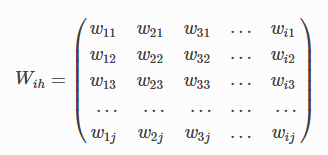

In [11]:
weights_input_to_hidden = np.random.rand(input_nodes,hidden_nodes)

##The hidden-layer
The same accounts for the weights for the connections of the hidden layer to the output layer. This can be modeled as a 10x200-Matrix W_ho: <br>
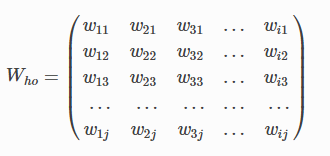

In [12]:
weights_output_to_hidden = np.random.rand(hidden_nodes,output_nodes)

# Train the model
As in task 2.1, this network can be trained the same way by “thinking” n-times and compare the final outputs (O) with the target data (T). The difference is, that the error of the hiddenlayer also needs to be backpropagated, and we have two weight matrices that need to be updated in each step of the training process. Further more, we are going to introduce a “learning rate” factor (LR) which allows more fine tuning for the learning process. <br>
<br>
We will bundle the code in a *NeuralNetwork* class. <br>
Training is performed by calling the ```model.fit``` method: <br>

1.   Feed the training data to the model using ```inputs```
2.   The model learns to associate image and labels
3.   The ```epochs``` parameter limit training to a number of full iteratinos of the training dataset



In [13]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.learning_rate = learning_rate
        # Initialize weights 
        self.weights_input_to_hidden = np.random.rand(self.input_nodes,self.hidden_nodes)
        self.weights_output_to_hidden = np.random.rand(self.hidden_nodes,self.output_nodes)

    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x)*(1-self.sigmoid(x))  
    
    def think(self, inputs, training=True):
        hidden_inputs = np.dot(inputs, self.weights_input_to_hidden)
        hidden_outputs = self.sigmoid(hidden_inputs)

        #implement dropout in the hidden layer
        #50% of the hidden layer will be effected by dropout if we are training
        if training:
          num_replaced = int(hidden_outputs.size * 0.5)
          indices_x = np.random.randint(0, hidden_outputs.shape[0], num_replaced)
          indices_y = np.random.randint(0, hidden_outputs.shape[1], num_replaced)
      
          hidden_outputs[indices_x, indices_y] = 0

        final_inputs = np.dot(hidden_outputs, self.weights_output_to_hidden)
        final_outputs = self.sigmoid(final_inputs)
        return hidden_outputs, final_outputs

    def fit(self, inputs, targets, epochs):
        for i in range(epochs):
            # Forwardpropagation
            hidden_outputs, final_outputs = self.think(inputs)
            # Backwardpropagation
            output_errors = targets - final_outputs
            hidden_errors = np.dot(output_errors, self.weights_output_to_hidden.transpose())
            self.weights_output_to_hidden += self.learning_rate * np.dot(hidden_outputs.transpose(), output_errors * self.sigmoid_derivative(final_outputs))
            self.weights_input_to_hidden += self.learning_rate * np.dot(inputs.transpose(), hidden_errors * self.sigmoid_derivative(hidden_outputs))

    
    def predict(self, input):
        hidden_outputs, final_outputs = self.think([input], training=False)
        return final_outputs

In [14]:
n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
n.fit(normalize(deepcopy(inputs[:1000])), deepcopy(targets[:1000]), 200) # Train the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The neural net we used in the previous section ended in a Sigmoid Layer, which means that its output was a vector of numbers between 0 and 1. When we're doing classification problems we'd like the output a 1 for the correct class and a0 for all the incorrect classes. Generally our predictions will not be perfect, but we'd at least like to precit an actual probability distribution over the classes. <br>
In or der to output probabilities we will overgo the sigmoid-layer and use the ```softmax``` function, which converts a vector of real numbers to a vector of probabilities.

In [15]:
def softmax(tensor):
    return np.exp(tensor)/np.sum(np.exp(tensor), axis=1, keepdims=True)   

# Make predictions and explore
With the model trained, we can use it to make predictions about some images.
<br><br>


plotting image: 


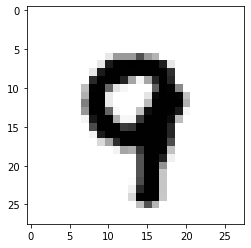

In [25]:
print("plotting image: ")
random_index = random.randint(0,len(test_inputs)-1)
image_array = np.asfarray(deepcopy(test_inputs[random_index])).reshape((28,28))
plt.imshow(image_array,cmap='Greys', interpolation='None')
plt.show(block = True)

In [26]:
test = normalize([deepcopy(test_inputs[random_index])])
result = n.predict(test)
print(result[0])
print("Predicted number:", np.argmax(result[0]))

[[1.72437920e-12 6.40724463e-09 1.98029597e-06 2.33601749e-06
  4.65136254e-06 3.21863661e-05 3.28777958e-05 6.04006414e-03
  5.23590435e-04 9.24987150e-01]]
Predicted number: 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
